## Байесовская линейная регрессия с библиотекой PYMC3 

В этой практике рассмотрим PYMC3 для байесовской линейной регрессии с оценкой апостериорных распределений вероятностей. 

In [10]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

Давайте создадим некоторые переменные для нашей регрессии. Наши истинные значния:
* $\alpha = 1$
* $\sigma = 1$
* $\beta = 2.5$

Наша итоговая переменная будет расчитана по:
$$ Y = \alpha + \beta_1 X + N(0,\sigma).$$

In [11]:
# фиксируем сид
np.random.seed(42)

# Задаем значения параметров
alpha, sigma = 1, 1
beta = [2.5]

# Размер датасета
size = 1000

# Генерируем вектора признаков
X = np.random.randn(size)

# Считаем
# Y = alpha + beta * X + np.random.randn(size)*sigma
Y = [1 if x > 1 else 0 for x in alpha + beta * X + np.random.randn(size)*sigma]

отрисовка

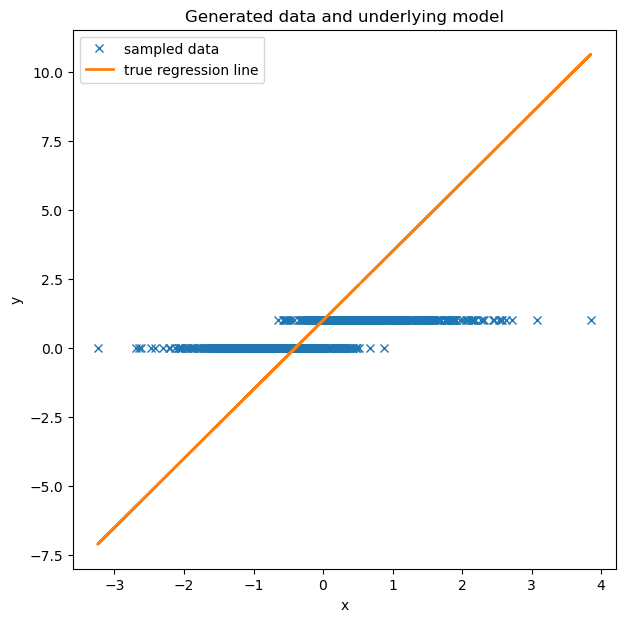

In [12]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(X, Y, "x", label="sampled data")
ax.plot(X, alpha + beta * X, label="true regression line", lw=2.0)
plt.legend(loc=0);

Теперь построим модель.

Априорные распределения:
* $\alpha \sim \mathcal{N}(\mu=0,\sigma=10)$
* $\beta[i] \sim \mathcal{N}(\mu=0,\sigma=10)$, where $i=1$
* $\sigma \sim \textrm{half-normal}(\sigma=1)$

Определим ожидаемое значение:
\begin{equation}
  \text{Y} = \alpha + \beta*X
\end{equation}

Байесовцы придерживаются вероятностного взгляда на мир и выражают эту модель в терминах вероятностных распределений. Нашу приведенную выше линейную регрессию можно переписать, чтобы получить:

\begin{equation}
  \text{Y}\sim \mathcal{N}(\mu=\mu,\sigma=\sigma).
\end{equation}

In [13]:
basic_model = pm.Model()

with basic_model:

    # Приоры для неизвестных параметров модели 
    alpha = pm.Normal('alpha', mu=0, sigma=100) #intercept
    beta = pm.Normal('beta', mu=0, sigma=100) #slope
    sigma = pm.HalfNormal('sigma', sigma=100)

    # # Ожидаемое значение переменной
    # mu = alpha + beta * X

    # # Вероятность (выборочное распределение) наблюдений / Likelihood (sampling distribution) of observations
    # likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=Y)
    
      # Ожидаемое значение переменной
    p = pm.math.sigmoid(alpha + beta * X + sigma)

    # Вероятность (выборочное распределение) наблюдений / Likelihood (sampling distribution) of observations
    likelihood = pm.Bernoulli('likelihood', p, observed=Y)

    # Получаем 5000 объектов из апостериорного распределения
    linear_trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


c:\Users\zhigu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 43 seconds.
c:\Users\zhigu\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 20000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [14]:
basic_model

     alpha ~ Normal(0, 100)
      beta ~ Normal(0, 100)
     sigma ~ HalfNormal(0, 100)
likelihood ~ Bernoulli(f(sigma, alpha, beta))

c:\Users\zhigu\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\zhigu\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\zhigu\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

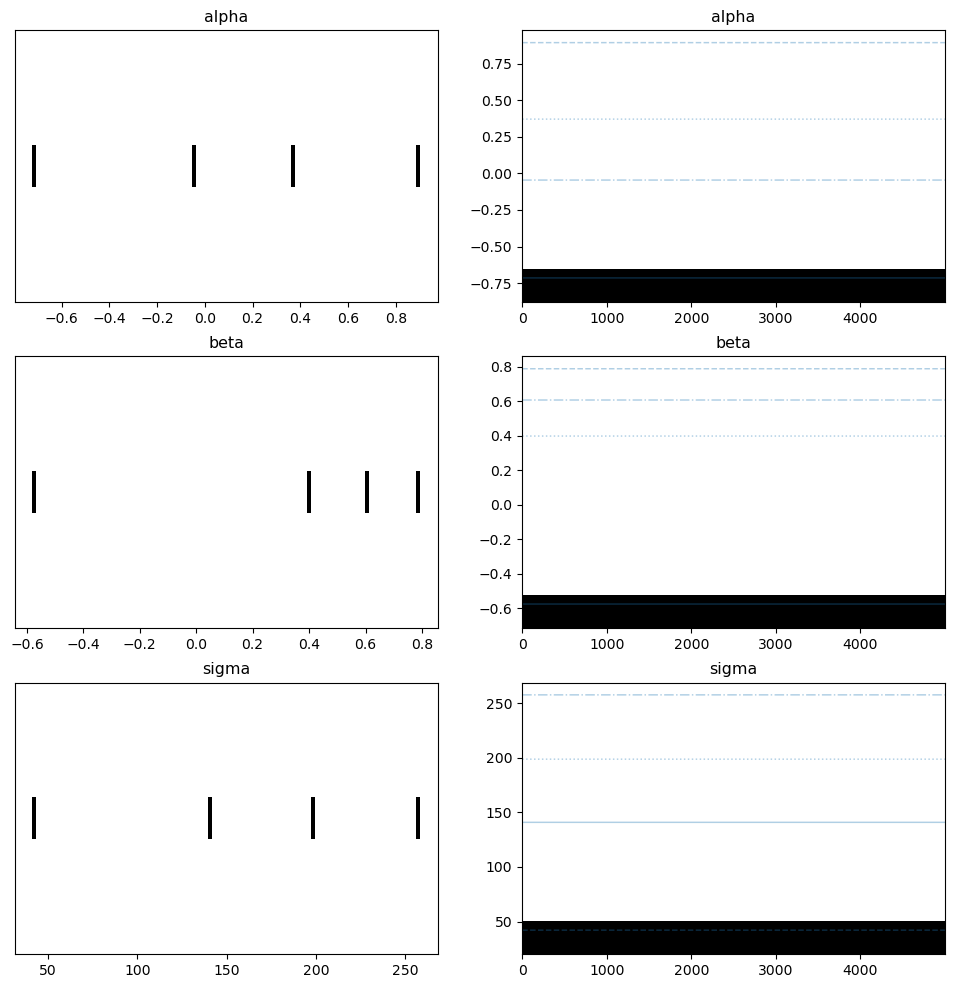

In [15]:
pm.plot_trace(linear_trace, figsize = (12, 12))

traceplot - это стандартный хороший способ просмотра апостериорных распределений вероятностей

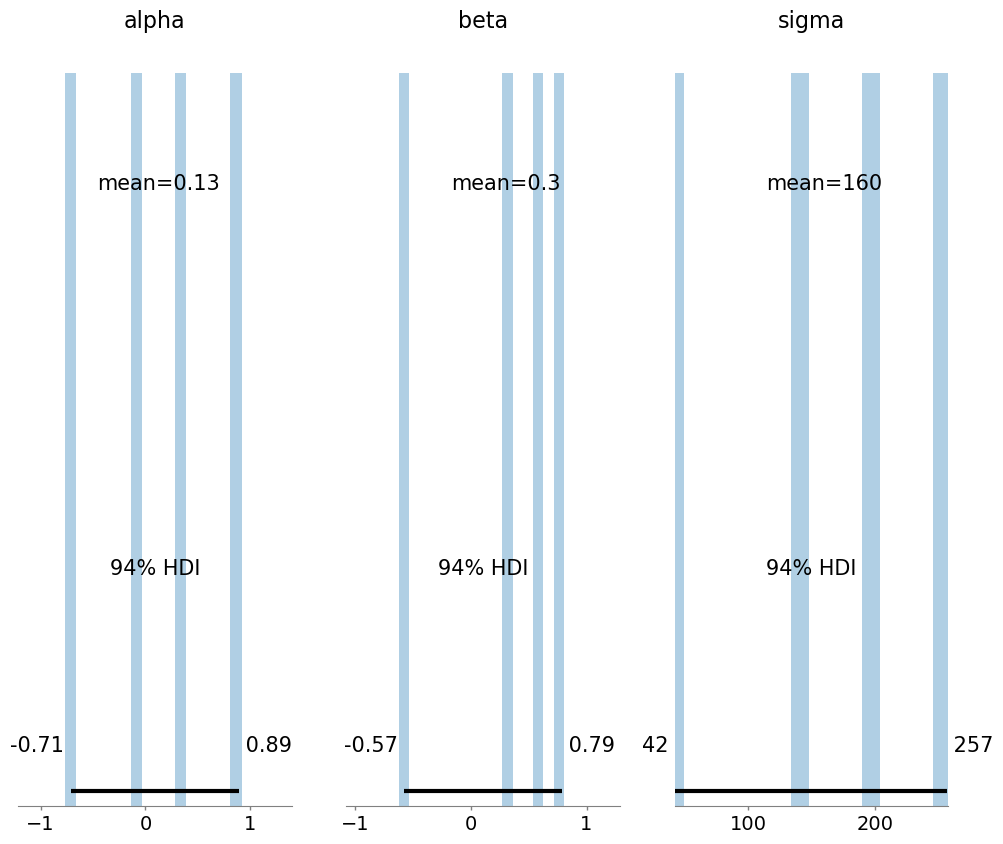

In [16]:
pm.plot_posterior(linear_trace, figsize = (12, 10), kind="hist");

Также есть встроенная функция сводки.

In [19]:
linear_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
sample['alpha']

AttributeError: module 'pymc' has no attribute 'plot_posterior_predictive_glm'

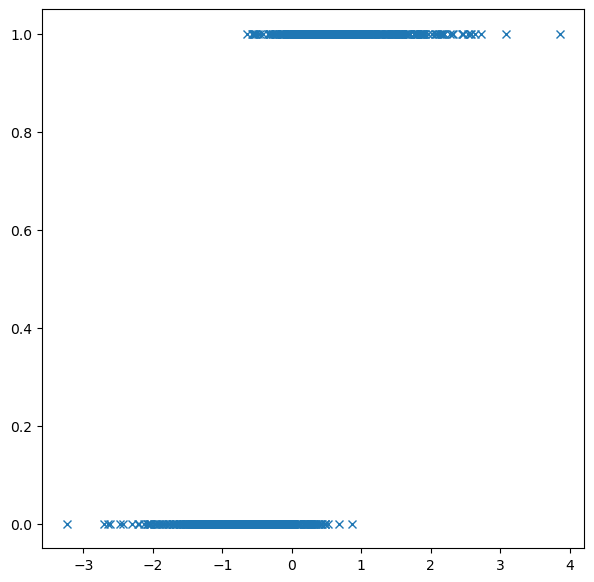

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(X, Y, "x", label="sampled data")
# pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(-2, 3, 50), linewidth = 1, 
#                                  color = 'y', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                # lm = lambda x, sample: sample['alpha'] + sample['beta'] * x);

az.plot_lm(linear_trace, samples = 100, eval=np.linspace(-2, 3, 50), linewidth = 1, 
                                 color = 'y', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['alpha'] + sample['beta'] * x);

plt.plot(X, alpha + beta * X, label="true regression line", lw=2.0)
plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
alpha = linear_trace['alpha'].mean() 
beta = linear_trace['beta'].mean()